# Particle orbits in Kerr space-time

In [312]:
%matplotlib notebook

In [341]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML


""""
Constants of motion:
    L = angular momentum
    E = energy
    Q = Carter's constant https://en.wikipedia.org/wiki/Carter_constant
    H = -1 if particle is massive, 0 if particle is massless (used sigma in latex document)

Units:
    G = c = M = 1
    [G] = L^3 M^-1 T^-2 = L^3 T^-2 (M=1)
    [c] = LT^-1
    => [L] = G/c^2 = 7.43e-28 m/kg
    => [T] = G/c^3 = 2.5e-36 s/kg

    E.g, if M = 1 solar mass, then L = 7.43e-28 m/kg * 2e30 kg = 1.49km per unit distance,
    and T = 2.5e-36 s/kg * 2e30 kg = 5e-6 s per unit time

"""

Delta = lambda r, M, a: r**2 - 2*M*r + a**2
Sigma = lambda r, theta, a: r**2 + a**2*np.cos(theta)**2
Kappa = lambda Q, L, a, E, M: (Q**2 + L**2 + a**2*(E**2+M))

def kerr_EOM(t, y, M, a, L, E, Q, H):
    """"
    Equations of motion for particle in Kerr orbit:

    Equations came from "Radiation transfer of emission lines in curved space-time, S. V. Fuerst, K. Wu",
    equations (21), (22), (24), (27), (30) and (31).

    Parameters
    ----------

    """

    r, theta, phi, t_prime, p_r, p_theta = y

    sigma = Sigma(r, theta, a)
    delta = Delta(r, M, a)
    kappa = Kappa(Q, L, a, E, M)
    factor = 1 / (sigma * delta)

    rd = (delta/sigma) * p_r
    thetad = p_theta/sigma
    phid = (2*a*r*E + (sigma - 2*r)*L/np.sin(theta)**2) * factor
    t_prime_d = E + (2*r*(r**2+a**2)*E - 2*a*r*L) * factor
    p_rd = factor * (((r**2 + a**2)*H - kappa) * (r - 1) + r*delta*H + 2*r*(r**2 + a**2)*E**2 - 2*a*E*L) - 2*p_r**2*(r - 1)/sigma
    p_thetad = np.sin(theta)*np.cos(theta)/sigma * (L**2/np.sin(theta)**4 - a**2*(E**2 + H))


    return [rd, thetad, phid, t_prime_d, p_rd, p_thetad]

def solve_EOM(t_span, y0, params, t_eval):
    """Solve equations of motion for Kerr black hole particle orbit"""
    # Solve ODE
    sol = solve_ivp(kerr_EOM, t_span, y0, args=params, method='Radau', t_eval=t_eval, rtol=1e-9, atol=1e-9)

    # Extract solution
    r = sol.y[0]
    theta = sol.y[1]
    phi = sol.y[2]

    # Convert from Boyer-Lindquist coordinates to Cartesian coordinates
    R = np.sqrt(r**2 + a**2)
    R=r
    x, y, z = R*np.sin(theta)*np.cos(phi), R*np.sin(theta)*np.sin(phi), R*np.cos(theta)

    return x, y, z

def plot_trajectory(x, y, z, params,title="Kerr orbit", show=True):
    # Plot the particle's orbit
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x, y, z)                                # Plot the orbit

    (M, a, L, E, Q, H) = params
    # Plot black hole event horizon surface
    Reh = M + np.sqrt(M**2 - a**2)
    u, v = np.mgrid[0:2*np.pi:200j, 0:np.pi:100j]
    xb = Reh * np.cos(u)*np.sin(v)
    yb = Reh * np.sin(u)*np.sin(v)
    zb = Reh * np.cos(v)
    ax.plot_wireframe(xb, yb, zb, color="r")

    # Plot the black hole ergoregion
    Rs = M + np.sqrt(M**2 - a**2 * np.cos(v))
    xe = Rs * np.cos(u)*np.sin(v)
    ye = Rs * np.sin(u)*np.sin(v)
    ze = Rs * np.cos(v)
    ax.plot_wireframe(xe, ye, ze, color="g")

    # Label axes
    ax.set_xlabel('x / Rs')
    ax.set_ylabel('y / Rs')
    ax.set_zlabel('z / Rs')
    plt.title(title)

    # Set false if want to continue working on plot
    if show:
        plt.show()
    else:
        return fig, ax

# Make animation of trajectory
def animate_traj(x, y, z, params, title="Kerr orbit", show=True):
    # Plot the particle's orbit
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # lines = [ax.plot([], [], [], color='blue')[0] for i in range(len(x))]
    line,  = ax.plot([],[],[], color='black')

    def update_traj(frame, line):
        # Update the position of each line based on the particle's current position
        # for i, line in enumerate(lines):
        #     line.set_data(x[:frame], y[:frame])
        #     line.set_3d_properties(z[:frame])
        line.set_data(x[:frame],y[:frame])
        line.set_3d_properties(z[:frame])

        # return lines
        return line,

    # Plot black hole event horizon surface
    (M, a, L, E, Q, H) = params
    Reh = M + np.sqrt(M**2 - a**2)
    u, v = np.mgrid[0:2*np.pi:200j, 0:np.pi:100j]
    xb = Reh * np.cos(u)*np.sin(v)
    yb = Reh * np.sin(u)*np.sin(v)
    zb = Reh * np.cos(v)
    ax.plot_wireframe(xb, yb, zb, color="r")

    # Plot the black hole ergoregion
    Rs = M + np.sqrt(M**2 - a**2 * np.cos(v))
    xe = Rs * np.cos(u)*np.sin(v)
    ye = Rs * np.sin(u)*np.sin(v)
    ze = Rs * np.cos(v)
    ax.plot_wireframe(xe, ye, ze, color="g")

    # Set plot limits and labels
    ax.set_xlim([-15, 15])
    ax.set_ylim([-15, 15])
    ax.set_zlim([-10, 10])
    ax.set_xlabel('x /GM/c^2')
    ax.set_ylabel('y /GM/c^2')
    ax.set_zlabel('z /GM/c^2')
    ax.set_title(title)

    # Create animation
    ani = animation.FuncAnimation(fig, update_traj, len(t), fargs=(line,), blit=True, repeat=True, frames=10)

    if show:
        plt.show()

    return ani



########################################################################################################################
###########################             Schwarzschild spacetime, ISCO               ####################################
########################################################################################################################


# Initial conditions, for massive particle circular orbit about a Schwarzschild (spin=0) black hole
r0 = 6.0 * 1.1
theta0 = np.pi/2
phi0 = 0.0
t_prime_0 = 0.0
p_r0 = 0.0
p_theta0 = np.sqrt(3) / 18

# Constants of motion
G = c = M = 1.0
a = 0.0

# See notebook for derivation of these constants
L = 2*np.sqrt(3)
E = -np.sqrt((1-2*M/r0)*(1+(L/r0)**2))
E = np.sqrt(8/9)
Q = p_theta0**2 + np.cos(theta0)**2 * (a**2 * (M**2-E**2)+(L**2/np.sin(theta0)**2)**2)
H = -1.0       # Massive particle

params = (M, a, L, E, Q, H)

y0 = [r0, theta0, phi0, t_prime_0, p_r0, p_theta0]

# Time
T = 10
dt = 1
t_span = [0.0, T]
t = np.arange(0.0, T, dt)

x, y, z = solve_EOM(t_span, y0, params, t)
# plot_trajectory(x, y, z, params)

ani = animate_traj(x, y, z, params)


In [344]:
plt.show()

In [ ]:
HTML(ani.to_html5_video())

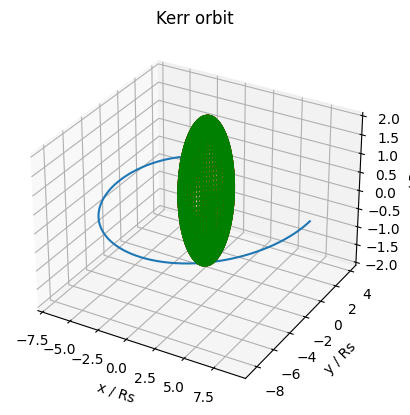

In [292]:

# Initial conditions, for massive particle circular orbit about a Schwarzschild (spin=0) black hole
r0 = 9.0
theta0 = np.pi/2
phi0 = 0.0
t_prime_0 = 0.0
p_r0 = 0.0
# p_theta0 = -22/(3*np.sqrt(3)) / r0**2

# Constants of motion
G = c = M = 1.0
a = 0.0

# See notebook for derivation of these constants
L = -22/(3*np.sqrt(3))
E = 5 / (3*np.sqrt(3))
Q = p_theta0**2 + np.cos(theta0)**2 * (a**2 * (M**2-E**2)+(L**2/np.sin(theta0)**2)**2)
H = -1.0       # Massive particle

p_theta0 = (1/Delta(r0, M, a)) * ((1-2*M/r0)*L + (2*M*a/r0)*E)
p_theta0 = np.sin(theta0)*np.cos(theta0)/Sigma(r0, theta0, a) * (L**2/np.sin(theta0)**4 - a**2*(E**2 + H))*3

params = (M, a, L, E, Q, H)

y0 = [r0, theta0, phi0, t_prime_0, p_r0, p_theta0]

# Time
T = 300
dt = 1e-3
t_span = [0.0, T]
t = np.arange(0.0, T, 1e-3)

x, y, z = solve_EOM(t_span, y0, params, t)
plot_trajectory(x, y, z, params)

In [332]:
# from IPython.display import HTML

# def plot_trajectory(x, y, z, params, title="Kerr orbit"):
#     # Plot the particle's orbit
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     lines = [ax.plot([], [], [], color='blue')[0] for i in range(len(x))]

#     def update_traj(frame, lines):
#         # Update the position of each line based on the particle's current position
#         for i, line in enumerate(lines):
#             line.set_data(x[:frame], y[:frame])
#             line.set_3d_properties(z[:frame])

#         return lines

#     # Plot black hole event horizon surface
#     (M, a, L, E, Q, H) = params
#     Reh = M + np.sqrt(M**2 - a**2)
#     u, v = np.mgrid[0:2*np.pi:200j, 0:np.pi:100j]
#     xb = Reh * np.cos(u)*np.sin(v)
#     yb = Reh * np.sin(u)*np.sin(v)
#     zb = Reh * np.cos(v)
#     ax.plot_wireframe(xb, yb, zb, color="r")

#     # Plot the black hole ergoregion
#     Rs = M + np.sqrt(M**2 - a**2 * np.cos(v))
#     xe = Rs * np.cos(u)*np.sin(v)
#     ye = Rs * np.sin(u)*np.sin(v)
#     ze = Rs * np.cos(v)
#     ax.plot_wireframe(xe, ye, ze, color="g")

#     # Set plot limits and labels
#     ax.set_xlim([-15, 15])
#     ax.set_ylim([-15, 15])
#     ax.set_zlim([-10, 10])
#     ax.set_xlabel('x /GM/c^2')
#     ax.set_ylabel('y /GM/c^2')
#     ax.set_zlabel('z /GM/c^2')
#     ax.set_title(title)

#     # Create animation
#     ani = animation.FuncAnimation(fig, update_traj, len(x), fargs=(lines,), blit=True, repeat=True)

#     # Convert animation to HTML video tag
#     anim_html = HTML(ani.to_jshtml())

#     return anim_html
def animate_trajectory(x, y, z, params, title="Kerr orbit", show=True):
    # Plot the particle's orbit
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    lines = [ax.plot([], [], [], color='blue')[0] for i in range(len(x))]

    def update_traj(frame, lines):
        # Update the position of each line based on the particle's current position
        for i, line in enumerate(lines):
            line.set_data(x[:frame], y[:frame])
            line.set_3d_properties(z[:frame])

        return lines

    # Plot black hole event horizon surface
    (M, a, L, E, Q, H) = params
    Reh = M + np.sqrt(M**2 - a**2)
    u, v = np.mgrid[0:2*np.pi:200j, 0:np.pi:100j]
    xb = Reh * np.cos(u)*np.sin(v)
    yb = Reh * np.sin(u)*np.sin(v)
    zb = Reh * np.cos(v)
    ax.plot_wireframe(xb, yb, zb, color="r")

    # Plot the black hole ergoregion
    Rs = M + np.sqrt(M**2 - a**2 * np.cos(v))
    xe = Rs * np.cos(u)*np.sin(v)
    ye = Rs * np.sin(u)*np.sin(v)
    ze = Rs * np.cos(v)
    ax.plot_wireframe(xe, ye, ze, color="g")

    # Set plot limits and labels
    ax.set_xlim([-15, 15])
    ax.set_ylim([-15, 15])
    ax.set_zlim([-10, 10])
    ax.set_xlabel('x /GM/c^2')
    ax.set_ylabel('y /GM/c^2')
    ax.set_zlabel('z /GM/c^2')
    ax.set_title(title)

    # Create animation
    ani = animation.FuncAnimation(fig, update_traj, len(x), fargs=(lines,), blit=True, repeat=True)

    if show:
        plt.show()

    return ani

In [334]:
animate_trajectory(x, y, z, params)

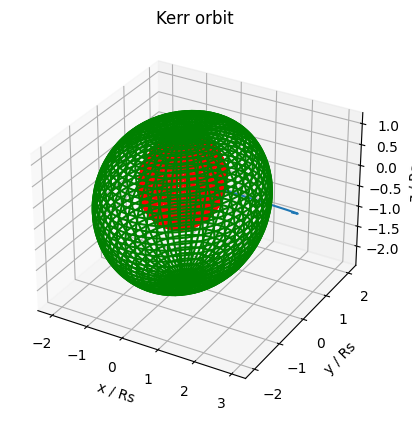

In [298]:

# Initial conditions, for massive particle circular orbit about a Schwarzschild (spin=0) black hole
r0 = 3
theta0 = np.pi/2
phi0 = 0.0
t_prime_0 = 0.0
p_r0 = 0.0
# p_theta0 = -22/(3*np.sqrt(3)) / r0**2

# Constants of motion
G = c = M = 1.0
a = 1.0

# See notebook for derivation of these constants
L = 2/np.sqrt(3)
E = 1/np.sqrt(3)
Q = p_theta0**2 + np.cos(theta0)**2 * (a**2 * (M**2-E**2)+(L**2/np.sin(theta0)**2)**2)
H = -1.0       # Massive particle

# p_theta0 = (1/Delta(r0, M, a)) * ((1-2*M/r0)*L + (2*M*a/r0)*E)
# p_theta0 = np.sin(theta0)*np.cos(theta0)/Sigma(r0, theta0, a) * (L**2/np.sin(theta0)**4 - a**2*(E**2 + H))*3
p_theta0 = L

params = (M, a, L, E, Q, H)

y0 = [r0, theta0, phi0, t_prime_0, p_r0, p_theta0]

# Time
T = 100
dt = 1e-3
t_span = [0.0, T]
t = np.arange(0.0, T, 1e-3)

x, y, z = solve_EOM(t_span, y0, params, t)
plot_trajectory(x, y, z, params)

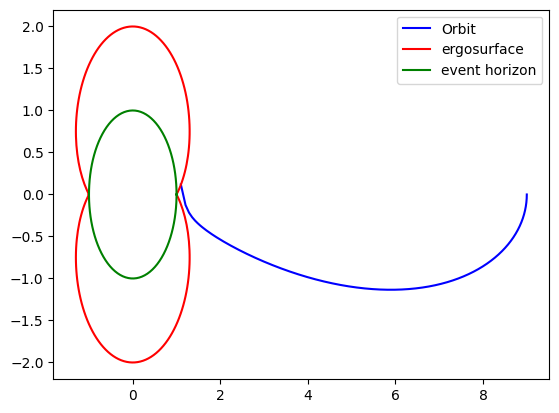

In [290]:
a=1.0
params = (M, a, L, E, Q, H)
Reh = M + np.sqrt(M**2 - a**2)
PHI , PSI = np.linspace(0, 2*np.pi, 200), np.linspace(0, np.pi, 200)
xb = Reh * np.cos(PHI) * np.sin(np.pi/2)
yb = Reh * np.sin(PHI) * np.sin(np.pi/2)
zb = Reh * np.cos(np.pi/2)

Rs = M + np.sqrt(M**2 - a**2 * np.cos(PHI)**2)
xe = Rs * np.cos(PHI)
ye = Rs * np.sin(PHI)

# x, y, _ = solve_EOM(t_span, y0, params, t)

plt.plot(x, y, 'b-', label = 'Orbit')
plt.plot(xe, ye, 'r-', label = 'ergosurface')
plt.plot(xb, yb, 'g-', label = 'event horizon')
plt.legend(loc="upper right")

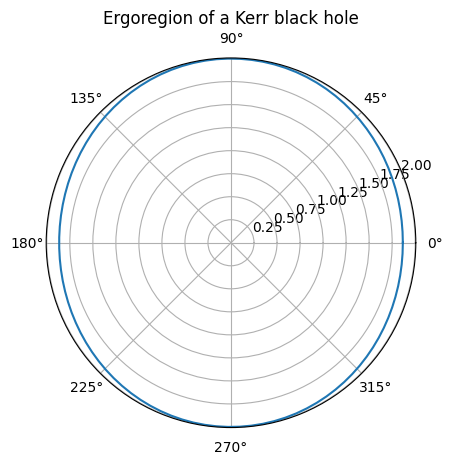

In [233]:
# Plot the ergoregion of a Kerr black hole in Python
# Use the formula r=M+sqrt(M^2-a^2 cos^2(theta)) and do a polar plot

import numpy as np
import matplotlib.pyplot as plt

# Define the parameters of the Kerr black hole
M = 1 # Mass
a = 0.5 # Angular momentum per unit mass

# Define the range of theta values
theta = np.linspace(0, 2*np.pi, 100)

# Calculate the radius of the ergoregion using the formula
r = M + np.sqrt(M**2 - a**2 * np.cos(theta)**2)

# Make a polar plot of the ergoregion
plt.polar(theta, r)
plt.title("Ergoregion of a Kerr black hole")
plt.show()

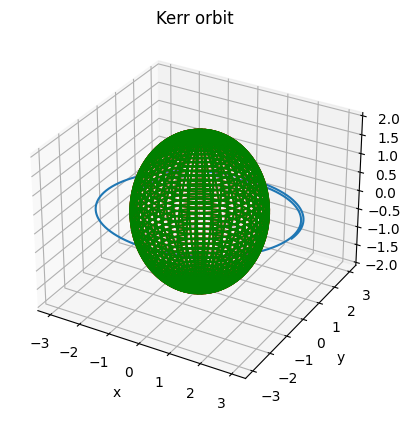

In [172]:
# Unstable circular photon orbit, Schwarzschild black hole
r0 = 3
theta0 = np.pi/2
phi0 = 0.0
t_prime_0 = 0.0
p_r0 = 0.0
p_theta0 = np.sqrt(3) / 18

# Constants of motion
G = c = M = 1.0
a = 0.0

# See notebook for derivation of these constants
L = 1
E = r0 * np.sqrt(1-2*M/r0)
E = 1 / (3*np.sqrt(3))
Q = p_theta0**2 + np.cos(theta0)**2 * (a**2 * (M**2-E**2)+(L**2/np.sin(theta0)**2)**2)
H = 0.0       # Massless particle

params = (M, a, L, E, Q, H)

y0 = [r0, theta0, phi0, t_prime_0, p_r0, p_theta0]

# Time
T = 200
dt = 1e-3
t_span = [0.0, T]
t = np.arange(0.0, T, 1e-3)

x, y, z = solve_EOM(t_span, y0, params, t)
plot_trajectory(x, y, z)

#### Start adding spin

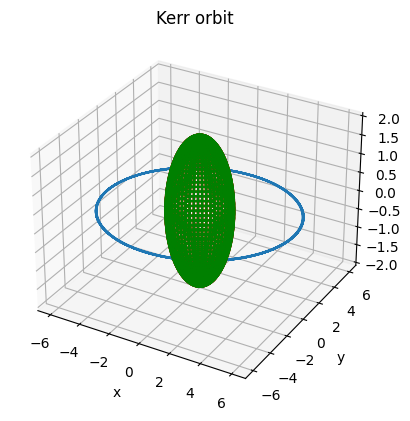

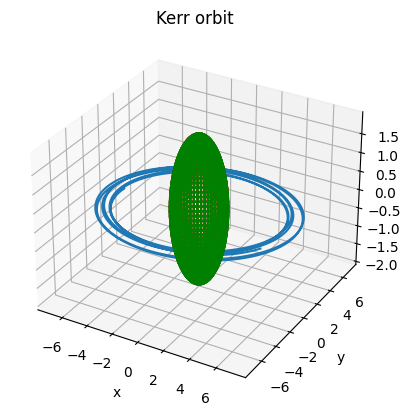

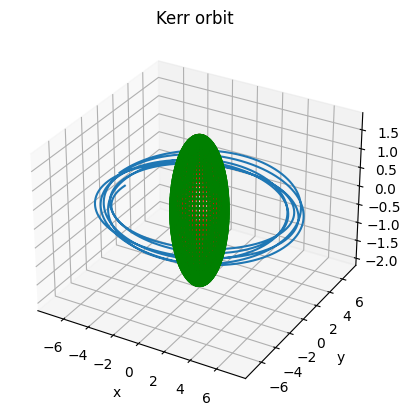

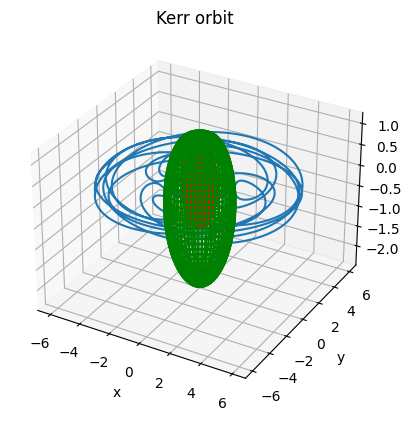

In [134]:
a = 0.00

# Initial conditions, for massive particle circular orbit about a Schwarzschild (spin=0) black hole
r0 = 6.0
theta0 = np.pi/2*3
phi0 = 0.0
t_prime_0 = 0.0
p_r0 = 0.0
p_theta0 = np.sqrt(3)/18


# See notebook for derivation of these constants
L = 2*np.sqrt(3)
E = -np.sqrt((1-2*M/r0)*(1+(L/r0)**2))
Q = p_theta0**2 + np.cos(theta0)**2 * (a**2 * (M**2-E**2)+(L**2/np.sin(theta0)**2)**2)
H = -1.0       # 0 for mass-less particles, -1 for massive particles

params = (M, a, L, E, Q, H)

y0 = [r0, theta0, phi0, t_prime_0, p_r0, p_theta0]

# Time
T = 500
dt = 1e-3
t_span = [0.0, T]
t = np.arange(0.0, T, 1e-3)

x, y, z = solve_EOM(t_span, y0, params, t)
plot_trajectory(x, y, z)

a = 0.1
params = (M, a, L, E, Q, H)
y0 = [r0, theta0, phi0, t_prime_0, p_r0, p_theta0]
x, y, z = solve_EOM(t_span, y0, params, t)
plot_trajectory(x, y, z)

a = 0.5
params = (M, a, L, E, Q, H)
y0 = [r0, theta0, phi0, t_prime_0, p_r0, p_theta0]
x, y, z = solve_EOM(t_span, y0, params, t)
plot_trajectory(x, y, z)

a = 1.0
params = (M, a, L, E, Q, H)
y0 = [r0, theta0, phi0, t_prime_0, p_r0, p_theta0]
x, y, z = solve_EOM(t_span, y0, params, t)
plot_trajectory(x, y, z)




In [189]:

def kerr_EOM(t, y, M, a, L, E, Q, H):
    """"
    Equations of motion for particle in Kerr orbit:

    Equations came from "Radiation transfer of emission lines in curved space-time, S. V. Fuerst, K. Wu",
    equations (21), (22), (24), (27), (30) and (31).

    Parameters
    ----------

    """

    r, theta, phi, t_prime, p_r, p_theta = y

    sigma = Sigma(r, theta, a)
    delta = Delta(r, M, a)
    kappa = Kappa(Q, L, a, E, M)
    factor = 1 / (sigma * delta)

    rd = (delta/sigma) * p_r
    thetad = p_theta/sigma
    phid = (2*a*r*E + (sigma - 2*r)*L/np.sin(theta)**2) * factor
    t_prime_d = E + (2*r*(r**2+a**2)*E - 2*a*r*L) * factor
    p_rd = factor * (((r**2 + a**2)*H - kappa) * (r - 1) + r*delta*H + 2*r*(r**2 + a**2)*E**2 - 2*a*E*L) - 2*p_r**2*(r - 1)/sigma
    p_thetad = np.sin(theta)*np.cos(theta)/sigma * (L**2/np.sin(theta)**4 - a**2*(E**2 + H))


    # theta -= a * t_prime_d


    return [rd, thetad, phid, t_prime_d, p_rd, p_thetad]

def solve_EOM(t_span, y0, params, t_eval):
    """Solve equations of motion for Kerr black hole particle orbit"""
    # Solve ODE
    sol = solve_ivp(kerr_EOM, t_span, y0, args=params, method='Radau', t_eval=t_eval, rtol=1e-9, atol=1e-9)

    # Extract solution
    r = sol.y[0]
    theta = sol.y[1]
    phi = sol.y[2]

    # Convert from polar to cartesian coordinates
    x, y, z = r*np.sin(theta)*np.cos(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta)

    return x, y, z

def plot_trajectory(x, y, z, title="Kerr orbit", show=True):
    # Plot the particle's orbit
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x, y, z)                                # Plot the orbit

    # Plot black hole event horizon surface
    Reh = M + np.sqrt(M**2 - a**2)
    u, v = np.mgrid[0:2*np.pi:200j, 0:np.pi:100j]
    xb = Reh * np.cos(u)*np.sin(v)
    yb = Reh * np.sin(u)*np.sin(v)
    zb = Reh * np.cos(v)
    ax.plot_wireframe(xb, yb, zb, color="r")

    # Plot the black hole ergoregion
    Rs = M + np.sqrt(M**2 - a**2 * np.cos(v))
    xe = Rs * np.cos(u)*np.sin(v)
    ye = Rs * np.sin(u)*np.sin(v)
    ze = Rs * np.cos(v)
    ax.plot_wireframe(xe, ye, ze, color="g")

    # Label axes
    ax.set_xlabel('x / Rs')
    ax.set_ylabel('y / Rs')
    ax.set_zlabel('z / Rs')
    plt.title(title)

    # Set false if want to continue working on plot
    if show:
        plt.show()
    else:
        return fig, ax


########################################################################################################################
###########################             Schwarzschild spacetime, ISCO               ####################################
########################################################################################################################


# Initial conditions, for massive particle circular orbit about a Schwarzschild (spin=0) black hole
r0 = 6.0
theta0 = np.pi/2
phi0 = 0.0
t_prime_0 = 0.0
p_r0 = 0.0
p_theta0 = np.sqrt(3) / 18


a = 1.0
# See notebook for derivation of these constants
L = 2*np.sqrt(3)
E = -np.sqrt((1-2*M/r0)*(1+(L/r0)**2))
E = 2*np.srqt(2)/3
Q = p_theta0**2 + np.cos(theta0)**2 * (a**2 * (M**2-E**2)+(L**2/np.sin(theta0)**2)**2)
H = -1.0       # Massive particle

params = (M, a, L, E, Q, H)

y0 = [r0, theta0, phi0, t_prime_0, p_r0, p_theta0]

# Time
T = 70
dt = 1e-3
t_span = [0.0, T]
t = np.arange(0.0, T, 1e-3)

x, y, z = solve_EOM(t_span, y0, params, t)
plot_trajectory(x, y, z)


AttributeError: module 'numpy' has no attribute 'srqt'

### Code that does not work

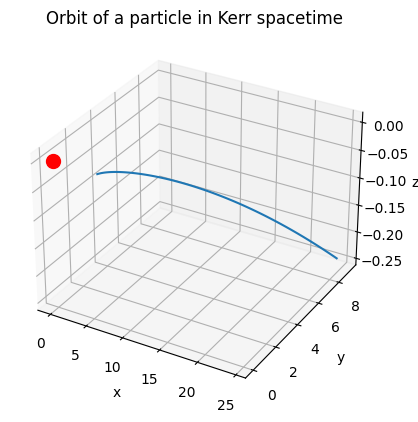

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from mpl_toolkits import mplot3d


# Define physical constants
G = 1               # gravitational constant
c = 1               # speed of light
M = 1               # mass of the black hole
Rs = 2*G*M/c**2     # Schwarzschild radius of the black hole

def geodesic_eqn_kerr(y, t, M, a):
    r, theta, phi, t, rd, thetad, phid, td = y

    # Define constants
    rho = np.sqrt(r**2 + a**2 * np.cos(theta)**2)
    Delta = r**2 - 2*M*r + a**2

    rdd = - Delta / rho**4 * (
            -M*td**2 + 4*a*M*np.sin(theta)**2 * td * phid - phid*np.sin(theta)**2 * (
                r*rho**2 + a**2*M*np.sin(theta)**2
        )
    )

    thetadd = -phid / rho**4 * (
        4*a*M*r*td*np.sin(2*theta)-np.sin(theta)*np.cos(theta) * phid * (
        (a**2+r**2)*rho**2 + 4*a**2*M*r*np.sin(theta)**2
            )
        )

    phidd_numerator = 2*(-2*a*M*rho**2 *rd*td+(4*a*M*r*(2*M*r-rho**2)/np.tan(theta))*td*thetad
                         + (-2*M*r**2*rho**2+r*rho**4)*rd*phid + (-2*M*r**3*rho**2+a**2*rho**4+r**2*rho**4-2*a**2*M*r*rho**2*np.cos(theta))/np.tan(theta)*thetad*phid + rd*phid*(6*a**2*M**2*r*np.sin(theta)**2+a**2*M*rho**2*np.sin(theta)**2)+4*a**2*M**2*r**2*np.sin(2*theta)*thetad*phid)
    phidd_denominator = -2*M*r**3*rho**2+a**2*rho**4+r**2*rho**4-2*a**2*M*r*rho**2*np.cos(theta)**2+12*a**2*M**2*r**2*np.sin(theta)**2

    phidd = phidd_numerator / phidd_denominator

    tdd_numerator = rd*td*(a**2*M*rho**2+M*r**2*rho**2-6*a**2*M**2*r*np.sin(theta)**2) + rd*phid*(-2*a**3*M*rho**2*np.sin(theta)**2+2*a*M*r**2*rho**2*np.sin(theta)**2) + td*thetad*(-8*a**2*M**2*r**2*np.sin(2*theta)) + thetad*phid*(4*a**3*M**2*r**2*np.sin(theta)**2*np.sin(2*theta))

    tdd_denominator = -2*M*r**3*rho**2+a**2*rho**4+r**2*rho**4-2*a**2*M*r*rho**2*np.cos(theta)**2+12*a**2*M**2*r**2*np.sin(theta)**2

    tdd =tdd_numerator / tdd_denominator


    return [rd, thetad, phid, td, rdd, thetadd, phidd, tdd]

def geodesic_eqn_kerr2(tau, y, M, a, e, l):
    r, theta, phi, t, rd, thetad = y

    # Define constants
    rho = np.sqrt(r**2 + a**2 * np.cos(theta)**2)
    Delta = r**2 - 2*M*r + a**2

    fac1 = (1-2*M/r)
    fac2 = 2*M*a/r

    td = (1/Delta)*((r**2+a**2+fac2*a)*e - fac2*l)
    phid = (1/Delta)*(fac1*l + fac2*e)

    rdd = - Delta / rho**4 * (
            -M*td**2 + 4*a*M*np.sin(theta)**2 * td * phid - phid*np.sin(theta)**2 * (
            r*rho**2 + a**2*M*np.sin(theta)**2
    )
    )

    thetadd = -phid / rho**4 * (
            4*a*M*r*td*np.sin(2*theta)-np.sin(theta)*np.cos(theta) * phid * (
            (a**2+r**2)*rho**2 + 4*a**2*M*r*np.sin(theta)**2
        )
    )

    return [rd, thetad, phid, td, rdd, thetadd]



a = 0.0*Rs
r0 = 3*Rs                      # initial radius
M = 0
phi0 = 0.00                     # initial azimuthal angle
theta0 = np.pi/2                # initial polar angle
v_r0 = 0.00                     # initial radial velocity
v_theta0 = np.sqrt(3)/18
e = -2/np.sqrt(3)
l = 2*np.sqrt(3)


# Define time span and initial state vector
N = 1000
T = 10
t0 = 0
t = np.linspace(t0, T, N)
dt = T/N
y_init = [r0, theta0, phi0, t0, v_r0 * dt, v_theta0 * dt]


y = solve_ivp(geodesic_eqn_kerr2, [t0, T], y_init, args=(M, a, e, l), rtol=1e-12, atol=1e-12)

# Extract positions and plot orbit
x0 = y.y[0]*np.sin(y.y[1])*np.cos(y.y[2])
y0 = y.y[0]*np.sin(y.y[1])*np.sin(y.y[2])
z0 = y.y[0]*np.cos(y.y[1])

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(x0, y0, z0)
ax.scatter3D(0, 0, 0, c='r', s=100)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.title('Orbit of a particle in Kerr spacetime')
plt.show()